In [45]:
import requests
import rasterio
import numpy as np
from pyproj import Proj, Transformer
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling

def utm_to_latlon(easting, northing, zone_number, hemisphere='N'):
    """
    Converte coordenadas UTM para latitude e longitude.
    
    Parâmetros:
    easting -- Coordenada leste (Easting) em UTM.
    northing -- Coordenada norte (Northing) em UTM.
    zone_number -- Número da zona UTM.
    hemisphere -- 'N' para Norte e 'S' para Sul.
    
    Retorna:
    (latitude, longitude) em graus decimais.
    """
    proj_utm = Proj(proj='utm', zone=zone_number, datum='WGS84', south=(hemisphere == 'S'))
    proj_latlon = Proj(proj='latlong', datum='WGS84')
    transformer = Transformer.from_proj(proj_utm, proj_latlon)
    lon, lat = transformer.transform(easting, northing)
    return lat, lon

def meters_to_degrees(meters, latitude):
    """
    Converte uma distância em metros para graus aproximadamente, considerando a latitude.

    Parâmetros:
    meters -- Distância em metros.
    latitude -- Latitude para calcular o comprimento de um grau de longitude.

    Retorna:
    (distância em graus de latitude, distância em graus de longitude)
    """
    # 1 grau de latitude é aproximadamente 111320 metros
    lat_degrees = meters / 111320
    
    # 1 grau de longitude depende da latitude
    lon_degrees = meters / (111320 * np.cos(np.radians(latitude)))
    return lat_degrees, lon_degrees

def download_srtm_from_opentopography_utm(easting, northing, zone_number, hemisphere, api_key, buffer_meters, output_filename='output_srtm_utm.tiff'):
    """
    Baixa dados SRTM para uma localização específica em UTM usando a API do OpenTopography,
    salva no formato .tiff e o reprojeta para o sistema UTM.

    Parâmetros:
    easting -- Coordenada leste (Easting) em UTM.
    northing -- Coordenada norte (Northing) em UTM.
    zone_number -- Número da zona UTM.
    hemisphere -- 'N' para Norte e 'S' para Sul.
    api_key -- Sua chave de API do OpenTopography.
    buffer_meters -- Distância em metros ao redor do ponto central.
    output_filename -- Nome do arquivo de saída no formato TIFF.
    """

    # Converte as coordenadas UTM para latitude/longitude
    lat, lon = utm_to_latlon(easting, northing, zone_number, hemisphere)

    # Converte a distância em metros para graus
    lat_buffer, lon_buffer = meters_to_degrees(buffer_meters, lat)

    # URL da API do OpenTopography para dados SRTM
    url = (
        f"https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south={lat - lat_buffer}&north={lat + lat_buffer}"
        f"&west={lon - lon_buffer}&east={lon + lon_buffer}&outputFormat=GTiff&API_Key={api_key}"
    )

    # Faz o download dos dados SRTM
    response = requests.get(url)
    
    if response.status_code == 200:
        print("Download do tile SRTM realizado com sucesso.")
        
        # Abre o arquivo TIFF na memória
        with MemoryFile(response.content) as memfile:
            with memfile.open() as src:
                # Define o sistema de coordenadas UTM de destino
                dst_crs = f"EPSG:326{zone_number}" if hemisphere == 'N' else f"EPSG:327{zone_number}"

                # Calcula a transformação e o perfil de reprojeção
                transform, width, height = calculate_default_transform(
                    src.crs, dst_crs, src.width, src.height, *src.bounds
                )
                profile = src.profile
                profile.update({
                    'crs': dst_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })

                # Reprojeta e salva o arquivo em UTM
                with rasterio.open(output_filename, 'w', **profile) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=dst_crs,
                            resampling=Resampling.nearest
                        )
                    
        print(f"Arquivo SRTM salvo como {output_filename} em coordenadas UTM (zona {zone_number}, hemisfério {hemisphere}).")
    elif response.status_code == 401:
        print("Erro de autenticação: Verifique a chave de API do OpenTopography.")
    else:
        print(f"Erro no download do tile SRTM: código de status {response.status_code}")

# Exemplo de uso: baixar SRTM para uma coordenada UTM específica
api_key = '09815d69a6cd696490eb8404ba986bbf'
download_srtm_from_opentopography_utm(easting=742907.93, northing=6944742.25, zone_number=22, hemisphere='S', api_key=api_key, buffer_meters=5000, output_filename='florianopolis_utm.tiff')


Download do tile SRTM realizado com sucesso.
Arquivo SRTM salvo como florianopolis_utm.tiff em coordenadas UTM (zona 22, hemisfério S).


In [46]:
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid

grid = Grid.from_raster('florianopolis_utm.tiff')
dem = grid.read_raster('florianopolis_utm.tiff')

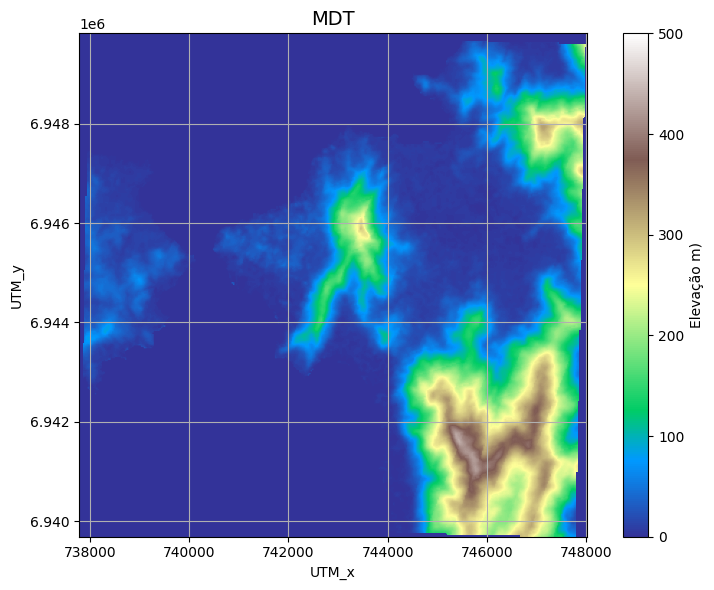

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

# Defina os valores mínimo e máximo para a escala da colorbar
vmin, vmax = 0, 500  # Ajuste esses valores conforme necessário para a sua escala de elevação

plt.imshow(dem, extent=grid.extent, cmap='terrain', vmin=vmin, vmax=vmax, zorder=1)
plt.colorbar(label='Elevação m)')
plt.grid(zorder=0)
plt.title('MDT', size=14)
plt.xlabel('UTM_x')
plt.ylabel('UTM_y')
plt.tight_layout()